# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

In [156]:
import pandas as pd
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [157]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [158]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [159]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

print(grad_f(1.0, 0.0)) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

[0.54030231 2.        ]
1.0


In [160]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [161]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [162]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

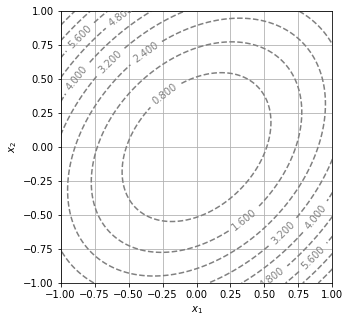

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [164]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

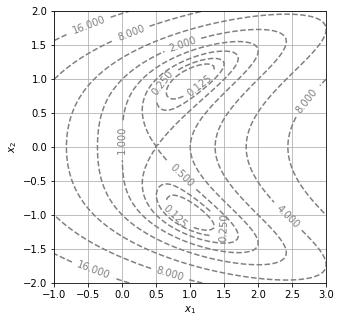

In [165]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [166]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

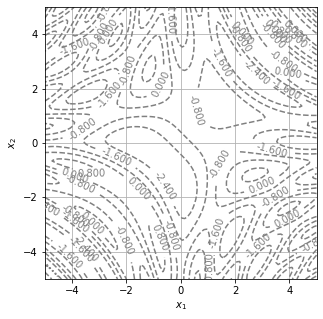

In [167]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [168]:
N = 1000
eps = 10**(-3)

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [169]:
def Newton(F, x0, y0, eps=eps, N=N, debug=False):
    j_f = J(F)
    for i in range(N):
        v = np.array([x0, y0])
        g = j_f(x0,y0)
        # print(x0, y0, F(x0,y0))
        x, y = v - np.dot(
            np.linalg.inv(g),
            F(x0, y0)
        )       
        if debug: 
            plt.scatter(x, y)
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

(0.4472135970019964, 0.4472135970019964)


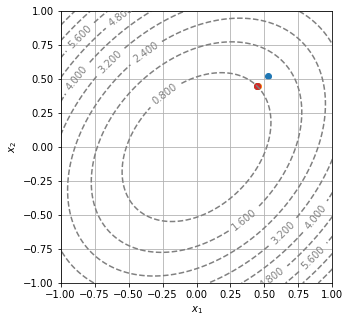

In [170]:
display_contour(
    f1,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)


def F1(x, y):
    c = 0.8
    return np.array([f1(x, y) - c, x - y])

# print(Newton(F1, -0.8, -0.8))
print(Newton(F1, 0.8, 0.8, debug=True))
# Newton(F1, 0.9, -0.9)

(0.11103604090823663, 0.11103604090823663)


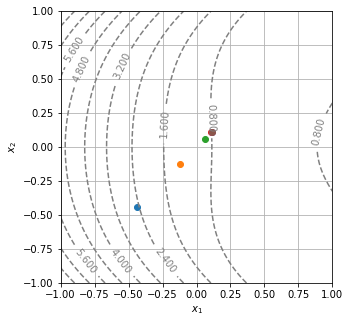

In [171]:
display_contour(
    f2,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)


def F2(x, y):
    c = 0.8
    return np.array([f2(x, y) - c, x - y])

# print(Newton(F1, -0.8, -0.8))
print(Newton(F2, 0.8, 0.8, debug=True))
# Newton(F1, 0.9, -0.9)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

- Utiliser comme point de départ: vecteur gradient normé * delta

In [182]:
def to_float(a, precision=2):
    try:
        return round(float(a._value), precision)
    except:
        return round(float(a), precision)

In [229]:
def level_curve(f, x0, y0, delta=.1, N=250, eps=eps):
    niveau = np.zeros(shape=(2, N))
    niveau[:, 0] = [x0, y0]
    c = f(x0, y0)
    
    for i in range(1, N):
        g = grad(f)(x0, y0)
        x_g, y_g = g / np.linalg.norm(g)
        x_recherche = x0 + delta * y_g
        y_recherche = y0 + delta * (-x_g)
        # plt.scatter(x_recherche, y_recherche)
        def dist_delta(x, y):
            ps = (x - x0)*y_g + (y - y0)*(-x_g)
            if ps >= 0:
                malus = 0
            else:
                malus = (2*ps)**2
            print(to_float(x), to_float(y), "malus", to_float(malus))
            return np.linalg.norm(np.array([x - x0, y - y0])) - delta + malus
            
        def F(x, y):
            return np.array([f(x, y) - c, dist_delta(x, y)])
        
        print('\n--- new x0,y0: ', x0, y0, x_recherche, y_recherche)
        x0, y0 = Newton(F, x_recherche, y_recherche)
        niveau[:, i] = [x0, y0]
    return niveau


--- new x0,y0:  1.0 1.5 1.284604989415154 1.5948683298050514
1.28 1.59 malus 0.0
1.28 1.59 malus 0.0
1.28 1.59 malus 0.0
1.29 1.58 malus 0.0
1.29 1.58 malus 0.0
1.29 1.58 malus 0.0

--- new x0,y0:  1.2883999780321853 1.5826166989114814 1.5800485644715303 1.6529096717318987
1.58 1.65 malus 0.0
1.58 1.65 malus 0.0
1.58 1.65 malus 0.0
1.58 1.64 malus 0.0
1.58 1.64 malus 0.0
1.58 1.64 malus 0.0

--- new x0,y0:  1.5829155793270948 1.639718908357825 1.8798450712500592 1.6825310191019858
1.88 1.68 malus 0.0
1.88 1.68 malus 0.0
1.88 1.68 malus 0.0
1.88 1.66 malus 0.0
1.88 1.66 malus 0.0
1.88 1.66 malus 0.0

--- new x0,y0:  1.8819596381120678 1.6636604327406515 2.1819593825986425 1.6640519783829393
2.18 1.66 malus 0.0
2.18 1.66 malus 0.0
2.18 1.66 malus 0.0
2.18 1.62 malus 0.0
2.18 1.62 malus 0.0
2.18 1.62 malus 0.0
2.18 1.61 malus 0.0
2.18 1.61 malus 0.0
2.18 1.61 malus 0.0

--- new x0,y0:  2.177404376786801 1.6115795975950624 2.439162612475636 1.465010071263467
2.44 1.47 malus 0.0
2.44 1.47 

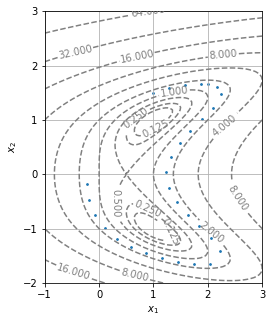

(2, 30)
0 [1.  1.5] 0.30000011044663855 0.0
1 [1.28839998 1.5826167 ] 0.3000001695495457 0.30000011044663855
2 [1.58291558 1.63971891] 0.3000009094725612 0.5994263474147136
3 [1.88195964 1.66366043] 0.3000000116667388 0.8970159087238235
4 [2.17740438 1.6115796 ] 0.17926986305902873 1.1826796155663593
5 [2.00421641 1.65787875] 0.3000000683764587 1.0165511762952697
6 [2.24919663 1.48471775] 0.3000003050974836 1.2492901053162206
7 [2.09835491 1.22539756] 0.30000004031589145 1.1321616575766837
8 [1.89175406 1.00787489] 0.3000000000006234 1.0185344487634223
9 [1.68045292 0.7949152 ] 0.30000000658802367 0.9798779254409241
10 [1.48041939 0.57133839] 0.30000000000160515 1.045569304442914
11 [1.3136619  0.32195528] 0.30000000182759085 1.2190870188283922
12 [1.22983767 0.03390407] 0.3000000012133731 1.4840022375348998
13 [ 1.28514071 -0.2609545 ] 0.3000000000001011 1.783890685411936
14 [ 1.4391068  -0.51843157] 0.30000009398552835 2.065642946986203
15 [ 1.63419288 -0.74633831] 0.3000000018987662

In [230]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 3.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
res = level_curve(f2, 1., 1.5, delta=.3, N=30)
# delta .3 marche pas


plt.scatter(res[0,:],res[1,:], s=3)
plt.show()

print(res.shape)

for i in range(res.shape[1] - 1):
    print(i, res[:, i], np.linalg.norm(res[:,(i+1)%N] - res[:,i]), np.linalg.norm(res[:,0] - res[:,i]))

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [209]:
def level_curve(f, x0, y0, delta=.1, N=250, eps=eps):
    niveau = np.zeros(shape=(2, N))
    niveau[:, 0] = [x0, y0]
    c = f(x0, y0)
    N_reel = N
    
    for i in range(1, N):
        g = grad(f)(x0, y0)
        x_g, y_g = g / np.linalg.norm(g)
        x_recherche = x0 + delta * y_g
        y_recherche = y0 + delta * (-x_g)
    
        def dist_delta(x, y):
            ps = (x - x0)*y_g + (y - y0)*(-x_g)
            if ps >= 0:
                malus = 0
            else:
                malus = ps**2
            print(to_float(x), to_float(y), "malus", to_float(malus))
            return np.linalg.norm(np.array([x - x0, y - y0])) - delta
            
        def F(x, y):
            return np.array([f(x, y) - c, dist_delta(x, y)])
        
        print('\n--- new x0,y0: ', x0, y0, x_recherche, y_recherche)
        
        x0, y0 = Newton(F, x_recherche, y_recherche)
        niveau[:, i] = [x0, y0]
        
        if np.linalg.norm(niveau[:, i] - niveau[:, 0]) <= delta:
            N_reel = i + 1
            break
        
    return niveau[:, :N_reel]


--- new x0,y0:  0.0 0.1 0.00019801941374528065 0.1999998039413667
0.0 0.2 malus 0.0
0.0 0.2 malus 0.0
0.0 0.2 malus 0.0

--- new x0,y0:  0.0007213720191785228 0.19999876759957377 0.002233986475561305 0.29998732693266117
0.0 0.3 malus 0.0
0.0 0.3 malus 0.0
0.0 0.3 malus 0.0
0.0 0.3 malus 0.0
0.0 0.3 malus 0.0
0.0 0.3 malus 0.0

--- new x0,y0:  0.003680010860186322 0.29995499031373046 0.008456319767465015 0.3998408595506864
0.01 0.4 malus 0.0
0.01 0.4 malus 0.0
0.01 0.4 malus 0.0
0.01 0.4 malus 0.0
0.01 0.4 malus 0.0
0.01 0.4 malus 0.0

--- new x0,y0:  0.011064287595014958 0.39968198005838557 0.021455060094687048 0.49914067423270125
0.02 0.5 malus 0.0
0.02 0.5 malus 0.0
0.02 0.5 malus 0.0
0.03 0.5 malus 0.0
0.03 0.5 malus 0.0
0.03 0.5 malus 0.0

--- new x0,y0:  0.025231770426175255 0.4986733055892345 0.043516799580725976 0.5969873824491493
0.04 0.6 malus 0.0
0.04 0.6 malus 0.0
0.04 0.6 malus 0.0
0.05 0.6 malus 0.0
0.05 0.6 malus 0.0
0.05 0.6 malus 0.0

--- new x0,y0:  0.0482304589199005

1.28 -1.5 malus 0.0
1.28 -1.5 malus 0.0
1.28 -1.5 malus 0.0
1.28 -1.5 malus 0.0

--- new x0,y0:  1.2843979499982814 -1.4977170700520765 1.1870458125916101 -1.4748574693916847
1.19 -1.47 malus 0.0
1.19 -1.47 malus 0.0
1.19 -1.47 malus 0.0
1.19 -1.47 malus 0.0
1.19 -1.47 malus 0.0
1.19 -1.47 malus 0.0

--- new x0,y0:  1.1874937093224933 -1.4730276354584595 1.0910645214762333 -1.4465434565716089
1.09 -1.45 malus 0.0
1.09 -1.45 malus 0.0
1.09 -1.45 malus 0.0
1.09 -1.44 malus 0.0
1.09 -1.44 malus 0.0
1.09 -1.44 malus 0.0

--- new x0,y0:  1.0915638368669327 -1.4447883081800532 0.9961635386785421 -1.4148085966142931
1.0 -1.41 malus 0.0
1.0 -1.41 malus 0.0
1.0 -1.41 malus 0.0
1.0 -1.41 malus 0.0
1.0 -1.41 malus 0.0
1.0 -1.41 malus 0.0

--- new x0,y0:  0.9967268516480037 -1.4130716521880138 0.9024887856095288 -1.3796174011976232
0.9 -1.38 malus 0.0
0.9 -1.38 malus 0.0
0.9 -1.38 malus 0.0
0.9 -1.38 malus 0.0
0.9 -1.38 malus 0.0
0.9 -1.38 malus 0.0

--- new x0,y0:  0.9031335554145219 -1.377853830

1.77 -0.63 malus 0.0

--- new x0,y0:  1.7672560115010547 -0.6289737834224488 1.830043132939758 -0.7068055081973857
1.83 -0.71 malus 0.0
1.83 -0.71 malus 0.0
1.83 -0.71 malus 0.0
1.83 -0.71 malus 0.0
1.83 -0.71 malus 0.0
1.83 -0.71 malus 0.0

--- new x0,y0:  1.8315227365823543 -0.7055883254534852 1.8971260478315568 -0.781061536284483
1.9 -0.78 malus 0.0
1.9 -0.78 malus 0.0
1.9 -0.78 malus 0.0
1.9 -0.78 malus 0.0
1.9 -0.78 malus 0.0
1.9 -0.78 malus 0.0

--- new x0,y0:  1.898226734073981 -0.780090518171828 1.9659189689297811 -0.853695961857925
1.97 -0.85 malus 0.0
1.97 -0.85 malus 0.0
1.97 -0.85 malus 0.0
1.97 -0.85 malus 0.0
1.97 -0.85 malus 0.0
1.97 -0.85 malus 0.0

--- new x0,y0:  1.9667140214949643 -0.8529567755350068 2.0359037261983466 -0.9251563930066996
2.04 -0.93 malus 0.0
2.04 -0.93 malus 0.0
2.04 -0.93 malus 0.0

--- new x0,y0:  2.036440902132187 -0.924641611273254 2.1066191191445562 -0.9958807708483416
2.11 -1.0 malus 0.0
2.11 -1.0 malus 0.0
2.11 -1.0 malus 0.0

--- new x0,y0: 

-0.36 0.65 malus 0.0

--- new x0,y0:  -0.3603191184108039 0.6533359775055316 -0.3171219485037688 0.7435246936069528
-0.32 0.74 malus 0.0
-0.32 0.74 malus 0.0
-0.32 0.74 malus 0.0
-0.31 0.74 malus 0.0
-0.31 0.74 malus 0.0
-0.31 0.74 malus 0.0

--- new x0,y0:  -0.31332211619636624 0.7416042156179673 -0.2626175461652971 0.8277961327446005
-0.26 0.83 malus 0.0
-0.26 0.83 malus 0.0
-0.26 0.83 malus 0.0
-0.26 0.83 malus 0.0
-0.26 0.83 malus 0.0
-0.26 0.83 malus 0.0

--- new x0,y0:  -0.25905870176598356 0.8256011319252683 -0.20137817902521393 0.907289303017242
-0.2 0.91 malus 0.0
-0.2 0.91 malus 0.0
-0.2 0.91 malus 0.0
-0.2 0.91 malus 0.0
-0.2 0.91 malus 0.0
-0.2 0.91 malus 0.0

--- new x0,y0:  -0.19817997922300923 0.9049344870998005 -0.13426942419657162 0.9818463909652796
-0.13 0.98 malus 0.0
-0.13 0.98 malus 0.0
-0.13 0.98 malus 0.0
-0.13 0.98 malus 0.0
-0.13 0.98 malus 0.0
-0.13 0.98 malus 0.0

--- new x0,y0:  -0.13148543014876315 0.9794451388170775 -0.062175522323555804 1.0515293720256043

2.09 -0.38 malus 0.0

--- new x0,y0:  2.0899920592380368 -0.38447869916792954 2.1341768637581193 -0.47418769007476164
2.13 -0.47 malus 0.0
2.13 -0.47 malus 0.0
2.13 -0.47 malus 0.0
2.14 -0.47 malus 0.0
2.14 -0.47 malus 0.0
2.14 -0.47 malus 0.0

--- new x0,y0:  2.1377191340400366 -0.472354329351396 2.18869849012652 -0.5583840059345817
2.19 -0.56 malus 0.0
2.19 -0.56 malus 0.0
2.19 -0.56 malus 0.0
2.19 -0.56 malus 0.0
2.19 -0.56 malus 0.0
2.19 -0.56 malus 0.0

--- new x0,y0:  2.1914888767045517 -0.556668117025567 2.2478146604598446 -0.6392962362365958
2.25 -0.64 malus 0.0
2.25 -0.64 malus 0.0
2.25 -0.64 malus 0.0
2.25 -0.64 malus 0.0
2.25 -0.64 malus 0.0
2.25 -0.64 malus 0.0

--- new x0,y0:  2.250000064201903 -0.6377633754851268 2.310512448742841 -0.7173765108157344
2.31 -0.72 malus 0.0
2.31 -0.72 malus 0.0
2.31 -0.72 malus 0.0
2.31 -0.72 malus 0.0
2.31 -0.72 malus 0.0
2.31 -0.72 malus 0.0

--- new x0,y0:  2.3122201903266943 -0.7160491079518039 2.376003991607427 -0.7930661625188282
2.38 

0.88 -1.76 malus 0.0
0.88 -1.76 malus 0.0
0.88 -1.76 malus 0.0

--- new x0,y0:  0.8851792151163153 -1.763334324604315 0.7893490301719643 -1.7347585367143636
0.79 -1.73 malus 0.0
0.79 -1.73 malus 0.0
0.79 -1.73 malus 0.0

--- new x0,y0:  0.7895762534521087 -1.7339965332643186 0.6942160198546604 -1.7038896262787098
0.69 -1.7 malus 0.0
0.69 -1.7 malus 0.0
0.69 -1.7 malus 0.0

--- new x0,y0:  0.6944662271064378 -1.7030971230172929 0.599623812024192 -1.6713967081719474
0.6 -1.67 malus 0.0
0.6 -1.67 malus 0.0
0.6 -1.67 malus 0.0

--- new x0,y0:  0.5999007018275276 -1.6705682995284605 0.5056317627522062 -1.6372011431375821
0.51 -1.64 malus 0.0
0.51 -1.64 malus 0.0
0.51 -1.64 malus 0.0

--- new x0,y0:  0.5059397515396085 -1.6363310127646071 0.4123092550517686 -1.6012122125652752
0.41 -1.6 malus 0.0
0.41 -1.6 malus 0.0
0.41 -1.6 malus 0.0

--- new x0,y0:  0.41265363839111385 -1.6002940495624955 0.31973772295208913 -1.5633260545109917
0.32 -1.56 malus 0.0
0.32 -1.56 malus 0.0
0.32 -1.56 malus 0.

2.9 2.02 malus 0.0
2.9 2.02 malus 0.0
2.9 2.02 malus 0.0
2.9 2.02 malus 0.0
2.9 2.02 malus 0.0

--- new x0,y0:  2.902497533605664 2.015028960130687 3.001247978231019 1.999269845742668
3.0 2.0 malus 0.0
3.0 2.0 malus 0.0
3.0 2.0 malus 0.0
3.0 1.99 malus 0.0
3.0 1.99 malus 0.0
3.0 1.99 malus 0.0

--- new x0,y0:  3.0004385351108587 1.9948408087002516 3.09718446537147 1.9695381412912825
3.1 1.97 malus 0.0
3.1 1.97 malus 0.0
3.1 1.97 malus 0.0
3.1 1.96 malus 0.0
3.1 1.96 malus 0.0
3.1 1.96 malus 0.0

--- new x0,y0:  3.0950020998385397 1.9623178736512137 3.186140119038579 1.9211613254930744
3.19 1.92 malus 0.0
3.19 1.92 malus 0.0
3.19 1.92 malus 0.0
3.18 1.91 malus 0.0
3.18 1.91 malus 0.0
3.18 1.91 malus 0.0
3.18 1.91 malus 0.0
3.18 1.91 malus 0.0
3.18 1.91 malus 0.0

--- new x0,y0:  3.1788774592186804 1.9078667571215242 3.2504280186858114 1.838006056867801
3.25 1.84 malus 0.0
3.25 1.84 malus 0.0
3.25 1.84 malus 0.0
3.23 1.81 malus 0.0
3.23 1.81 malus 0.0
3.23 1.81 malus 0.0
3.23 1.82 malus 

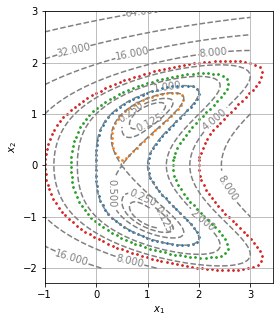

(2, 150)
0 0.10000000401580673 0.0
1 0.10000000434410403 0.10000000401580673
2 0.1000000031232173 0.1995592217287768
3 0.10000000160310081 0.29829621552285784
4 0.10000000066106333 0.3960233886746078
5 0.10000000024648521 0.49276584771405524
6 0.10000000009086683 0.588690103711642
7 0.10000000003486503 0.6840182788635657
8 0.10000000001414543 0.7789703654877789
9 0.1000000000059907 0.8737377145554449
10 0.10000000000255445 0.9684765361215047
11 0.10000000000103104 1.063310997181857
12 0.10000310843166225 1.1583397381268092
13 0.10000137083518906 1.2536457998663781
14 0.1000003382839589 1.3492928682359893
15 0.10000000209255443 1.445343229349202
16 0.10000058699903312 1.5418578621290537
17 0.10000277341735465 1.6389007460208704
18 0.10000000000861023 1.736542166589855
19 0.10000000007770216 1.8348504931602307
20 0.10000000072384611 1.933888722008418
21 0.10000000785308795 2.0336256331452303
22 0.10000005710390432 2.133562288175999
23 0.10000003689915186 2.230601617760833
24 0.1000000096

In [210]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 3.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

# delta .3 marche pas
res = level_curve(f2, 0., 0.1, delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

res = level_curve(f2, 0.5, 0.1, delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

res = level_curve(f2, 1.5, 0.1, delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

res = level_curve(f2, 2., 0.1, delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

plt.show()

print(res.shape)
for i in range(res.shape[1]):
    print(i, np.linalg.norm(res[:,(i+1)%res.shape[1]] - res[:,i]), np.linalg.norm(res[:,0] - res[:,i]))

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

**Réponse**\
Le problème principal réside dans les dimensions du grand carré dans lequel on veut plonger $K$. En effet, selon la forme de la courbe de niveau, l'ensemble de sous-niveau auquel on s'intéresse peut être excentré par rapport à l'origine, constitué d'une réunion d'ensembles disjoints, etc. Le nombre élevé d'éventualités à prendre en compte complique la mise en place d'un algorithme systématique pour trouver la taille du grand carré.\

Pour pallier à ce problème, on peut imaginer d'utiliser une approche utilisant la fonction `level_curve`: on utilise tout d'abord `Newton` pour trouver un point de la courbe de niveau associée à $K$, puis on utilise `level_curve` pour discrétiser cette courbe; enfin, on cherche le maximum des abscisses et des ordonnées  en valuer absolue parmi les points. On peut alors tracer le grand carré.\

Néanmoins, cette méthode (en plus de rendre la méthode des carrés dépendante de la fonction `level_curve`), ne fonctionnera pas dans tous les cas: si l'ensemble de sous-niveau est composé d'ensembles disjoints, il se peut que l'on ne trouve qu'un des sous-ensembles de l'ensemble, les autres n'étant pas compris dans le carré. Par ailleurs, si la "direction" que l'on donne à la fonction `Newton` pour rechercher un point de l'ensemble ne rencontre pas l'ensemble, la convergence en moins de $N$ étapes de `Newton` n'est pas garantie.\

Aussi, deux approches sont possibles: soit on essaye d'appliquer la fonction `taille_grand_carre` au risque de provoquer une erreur, soit on suppose que l'utilisateur a rentré les dimensions du grand carré dans lequel on plonge K. Cela justifie le paramètre optionnel que l'on a ajouté à la fonction `area_squares`.

In [33]:
def taille_grand_carre(f,c):
    '''permet de déterminer le côté du carré dans lequel plonger l'ensemble K,
    en prenant le max des abscisse et des ordonnées données par level_curve(),
    après avoir utilisé Newton pour déterminer un point de la ligne de niveau'''
    #on part de l'origine
    def F(x,y):
        return np.array([f(x,y)-c, x-y])
    x,y = Newton(F,0.1, 0.1)
    coords = level_curve(f, x, y, delta = .01, N = 1000)
    x_max = max(coords[0,:])
    y_max = max(coords[1,:])
    return 2*((x_max**2 + y_max)**2)**0.5 + 1 #pour être sûr que le carré contienne bien tout l'ensemble

def area_squares(f,c,h, cote_carre = 0):
    if not cote_carre: # la taille du carré intial n'a pas été renseignée, on tente d'appliquer la fonction taille_grand_carree
        cote_carre = taille_grand_carre(f,c) #quel taille pour le carré initial ?
    cellule = h**2
    aire = 0
    coords = [-cote_carre/2 + (1/2+k)*h for k in range(int(cote_carre/h-1/2)+1)] #regarder arange et linspace
    #coords2 = np.linspace(-cote_carre/2 + h/2,cote_carre/2, )
    #on passe par chaque cellule de centre (i,j)
    for i in coords:
        for j in coords:
            if f(i,j) <= c:
                aire += cellule
    return aire

def f_test(x,y):
    return (x**2+y**2)**0.5

print(area_squares(f1,0.8,0.01))

0.8888999999999184


In [ ]:
#courbe de l'erreur
values_h = np.linspace(0.1,0.001, 100)
ords = [abs(np.pi - area_squares(f_test,1,h)) for h in values_h]

plt.loglog(values_h, ords)
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [ ]:
#à faire

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

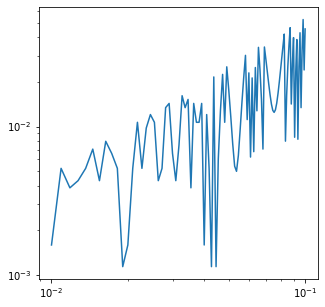

In [86]:
p = [0,0]

def aire_BN(f, x0, y0, delt, n):
    res = level_curve(f, x0 ,y0 , delta = delt, N=n)
    N = np.shape(res)[1]
    #print(res[1,249:250])
    aire = 0
    for i in range(1,N):
        zi = res[:,i-1:i]
        #print(zi[0,0],zi[1,0])
        zi_1 = res[:,i:i+1]
        #print(i, zi, zi_1)
        aire += ( zi_1[0,0]*(zi[1,0]-p[1]) + zi[0,0]*(p[0] - zi_1[1,0]) )/2
        #print(aire)

    return aire

#courbe de l'erreur - pour le disque unité
values_delta = np.linspace(0.1,0.01, 100)
ords = [abs(np.pi - aire_BN(f_test,1.,0.,delta, 1000)) for delta in values_delta]

plt.loglog(values_delta, ords)
plt.show()

# que veut dire étudier numériquement la vitesse de convergence ?

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [89]:
def area_triangles(x,y):
    #Le point p est l'origine du repère.
    p = [0,0]
    aire  = 0
    for i in range(len(x)-1):
        aire += ( x[i+1]*(y[i]-p[1]) + x[i]*(p[0] - y[i+1]) )/2
    return aire

res = level_curve(f_test, 1., 0.,delta = 0.01, N = 1000)
x = res[0,:]
y = res[1,:]
print(area_triangles(x,y))

3.140000000000416
